## Heisenberg-limit algorithm for ground state energy estimation

In [1]:
# general imports
import numpy as np
import math
from math import pi
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

from braket.circuits import Circuit, circuit, Instruction
from braket.devices import LocalSimulator

from braket.tracking import Tracker

from scipy.special import iv
from scipy.linalg import expm, block_diag
from openfermion import fermi_hubbard, jordan_wigner, get_sparse_operator

In [2]:
tracker = Tracker().start()
device = LocalSimulator()

## Fermi-Hubbard Model

$$
H = -\frac{t}{2} \sum_{j,\sigma}(X_{j,\sigma}X_{j+1,\sigma}+Y_{j,\sigma}Y_{j+1,\sigma}) + \frac{U}{4} \sum_j Z_{j,\uparrow}Z_{j,\downarrow}
$$

We wanna find the ground state energy of it.

In [3]:
hubbard = fermi_hubbard(1, 4, 1, 4, periodic=False,particle_hole_symmetry=True)
jw_hamiltonian = jordan_wigner(hubbard)
jw_hamiltonian = jordan_wigner(hubbard)
fh_matrix = get_sparse_operator(jw_hamiltonian)
fh_matrix = fh_matrix.todense()
fh_matrix = fh_matrix.real

#plt.matshow(fh_matrix)

### Why $\tau$?

We need to normalize $H$ such that all its eigenvalue fall in [$-\pi/3$, $\pi/3$]. 

In [4]:
norm = np.linalg.norm(fh_matrix)
tau = np.pi/(4*norm)

### Cumulative Distribution Function(CDF) for H

Given a initial state $\rho$, we can find the CDF for H, which is a ladder-like function from 0 t0 1. We choose the Hatree Fock state as the initial state(one occupation on each site and opposite spin for neighboring occupations).

In [5]:
def get_real_CDF(N_sites, t, U, precision):
    norm = np.linalg.norm(fh_matrix)
    tau = np.pi/(4*norm)
    
    Ndim = 2**(2*N_sites)
    energy, eigenstate= np.linalg.eig(tau*fh_matrix)

    hf_state = np.zeros(Ndim)
    hf_index = 0
    for i in range(N_sites):
        if i%2==0:
            hf_index += 2**(2*i)
        elif i%2!=0:
            hf_index += 2**(2*i+1)

    hf_state[hf_index] = 1
        

    energy=energy.real
    eigenstate[np.abs(eigenstate)<1e-10]=0
    eigenstate = np.array(eigenstate)

    prob_raw = np.zeros(Ndim)
    for i in range(Ndim):
        prob_raw[i] = np.abs(np.dot(hf_state,eigenstate[:,i]))**2
    prob = []
    ener = []
    for i,ele in enumerate(prob_raw):
        if ele!=0:
            prob.append(ele)
            ener.append(energy[i].real)

    x_list = np.linspace(-np.pi/3, np.pi/3, precision)
    CDF = np.zeros(len(x_list))

    for j,ener_ele in enumerate(ener):
        for i,x_ele in enumerate(x_list):
            if x_ele>ener_ele:
                CDF[i] += prob[j]

    return CDF

Text(0.5, 1.0, 'CDF for tau*H')

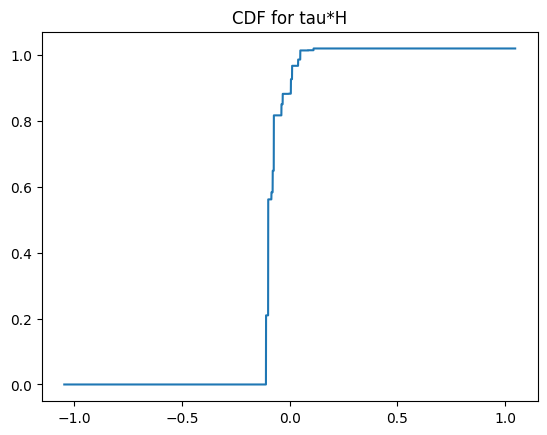

In [6]:
plt.plot(np.linspace(-np.pi/3, np.pi/3, 10000), get_real_CDF(4, 1, 4, 10000))
plt.title('CDF for tau*H')

In [7]:
## Get Trotterization Hamiltonian Evolution Gate:

def fh_evolution(N_sites, t, U, tau, j, step):
    
    qc = Circuit()
    
    for _ in range(step):
        
        ## Hopping terms 
        theta = tau*t*j/step
        
        for i in range(N_sites//2):
            qc.xx(2*i,2*i+1,theta)
            qc.yy(2*i,2*i+1,theta)

            qc.xx(2*i+N_sites,2*i+1+N_sites,theta)
            qc.yy(2*i+N_sites,2*i+1+N_sites,theta)
            
        for i in range((N_sites-1)//2):
            qc.xx(2*i+1,2*i+2,theta)
            qc.yy(2*i+1,2*i+2,theta)

            qc.xx(2*i+N_sites+1,2*i+2+N_sites,theta)
            qc.yy(2*i+N_sites+1,2*i+2+N_sites,theta)
        
        ## Potential
        gamma = tau*j*U/(2*step)
        
        for i in range(N_sites):
            qc.zz(i,i+N_sites,gamma)
    return qc

In [8]:
print(fh_evolution(4, 1, 2, 0.5, 1, 1))

T  : |   0    |   1    |            2             |   3    |        4        |
                                                                              
q0 : -XX(0.50)-YY(0.50)----------ZZ(0.50)-------------------------------------
      |        |                 |                                            
q1 : -XX(0.50)-YY(0.50)-XX(0.50)-|-----------------YY(0.50)-ZZ(0.50)----------
                        |        |                 |        |                 
q2 : -XX(0.50)-YY(0.50)-XX(0.50)-|-----------------YY(0.50)-|--------ZZ(0.50)-
      |        |                 |                          |        |        
q3 : -XX(0.50)-YY(0.50)----------|--------ZZ(0.50)----------|--------|--------
                                 |        |                 |        |        
q4 : -XX(0.50)-YY(0.50)----------ZZ(0.50)-|-----------------|--------|--------
      |        |                          |                 |        |        
q5 : -XX(0.50)-YY(0.50)-XX(0.50)----------|--------Y

In [9]:
def czz_gate(angle):
    qc = Circuit()
    qc.cnot(1,2)
    qc.cphaseshift(0,2,angle)
    qc.cnot(1,2)
    
    return qc

def cxx_gate(angle):
    qc = Circuit()
    qc.h([1,2])
    qc.cnot(1,2)
    qc.cphaseshift(0,2,angle)
    qc.cnot(1,2)
    qc.h([1,2])
    return qc

def cyy_gate(angle):
    qc = Circuit()
    qc.rx([1,2],pi/2)
    qc.cnot(1,2)
    qc.cphaseshift(0,2,angle)
    qc.cnot(1,2)
    qc.rx([1,2],-pi/2)
    
    return qc

In [10]:
# ## Get circuit for Hadamard Test

# ## This function doesn't work properly! Please use get_new_Hadamard_circuit
# ##

# def get_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='real'):
    
#     num_qubits = 2*N_sites+1
#     qc = Circuit()
    
#     qc.h(0)
    
#     ## State Initialization
#     for i in range(N_sites):
#         if i%2!=0:
#             qc.x(i+1)
#         else:
#             qc.x(i+1+N_sites)
            
#     ## Control-Evolution Gate
    
#     for _ in range(step):
        
#         ## Hopping terms 
#         theta = tau*t*j/step    
#         for i in range(N_sites//2):
#             #qc.cxx(num_qubits-1,[2*i,2*i+1],theta)
#             qc.add_circuit(cxx_gate(theta),[0, 2*i+1, 2*i+2])
            
#             #qc.cyy(num_qubits-1,[2*i,2*i+1],theta)
#             qc.add_circuit(cyy_gate(theta),[0, 2*i+1, 2*i+2])
            
#             #qc.cxx(num_qubits-1,2*i+N_sites,2*i+1+N_sites,theta)
#             qc.add_circuit(cxx_gate(theta),[0, 2*i+1+N_sites, 2*i+2+N_sites])
            
#             #qc.cyy(num_qubits-1,2*i+N_sites,2*i+1+N_sites,theta)
#             qc.add_circuit(cyy_gate(theta),[0, 2*i+1+N_sites, 2*i+2+N_sites])

            
            
#         for i in range((N_sites-1)//2):
#             #qc.cxx(num_qubits-1,[2*i+1,2*i+2],theta)
#             qc.add_circuit(cxx_gate(theta),[0, 2*i+2, 2*i+3])
            
#             #qc.cyy(num_qubits-1,[2*i+1,2*i+2],theta)
#             qc.add_circuit(cyy_gate(theta),[0, 2*i+2, 2*i+3])
            
#             qc.add_circuit(cxx_gate(theta),[0, 2*i+2+N_sites, 2*i+3+N_sites])
#             qc.add_circuit(cyy_gate(theta),[0, 2*i+2+N_sites, 2*i+3+N_sites])
        
#         ## Potential terms
#         gamma = tau*U*j/(2*step)
#         for i in range(N_sites):
#             qc.add_circuit(czz_gate(gamma),[0, i+1, i+1+N_sites])
    
#     if test_type=='real':
#         pass
#     elif test_type=='imag':
#         qc.si(0)
    
#     qc.h(0)
    
#     qc.probability(target=0)
#     return qc


In [11]:
def get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='real'):
    num_qubits = 2*N_sites+2
    qc = Circuit()

    qc.h([0,1])

    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.s(0)

    ## Control-UI gate
    for i in range(N_sites):
        if i%2!=0:
            qc.cnot(0,i+2)
        else:
            qc.cnot(0, i+2+N_sites)

    ## Control-UR gate, but pass

    ## evolution
    qc.add_circuit(fh_evolution(N_sites, t, U, tau, j, step), range(2,num_qubits))

    ## Control-UI_dagger gate
    for i in range(N_sites):
        if i%2!=0:
            qc.cnot(1,i+2)
        else:
            qc.cnot(1, i+2+N_sites)

    qc.h([0,1])

    qc.probability(target=range(num_qubits))
    return qc

In [12]:
job = device.run(get_new_Hadamard_circuit(4, 1, 4, 0.5, 1, 1),shots=1000)
res = job.result()

In [15]:
def get_new_Z(N_sites, t, U, tau, j, step, shots):

    qc_real = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='real')
    qc_imag = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='imag')

    device = LocalSimulator()
    job_real = device.run(qc_real, shots=shots)
    job_imag = device.run(qc_imag, shots=shots)
    res_real = job_real.result()
    res_imag = job_imag.result()

    probs_real = res_real.measurement_probabilities
    p00, p01, p10, p11 = 0,0,0,0
    if ('00'+'0'*2*N_sites) in probs_real.keys():
        p00 = probs_real['00'+'0'*2*N_sites]
    if ('01'+'0'*2*N_sites) in probs_real.keys():
        p01 = probs_real['01'+'0'*2*N_sites]
    if ('10'+'0'*2*N_sites) in probs_real.keys():
        p10 = probs_real['10'+'0'*2*N_sites]
    if ('11'+'0'*2*N_sites) in probs_real.keys():
        p11 = probs_real['11'+'0'*2*N_sites]
        
    X = p00+p11-p01-p10 

    probs_imag = res_imag.measurement_probabilities
    p00, p01, p10, p11 = 0,0,0,0
    if ('00'+'0'*2*N_sites) in probs_imag.keys():
        p00 = probs_imag['00'+'0'*2*N_sites]
    if ('01'+'0'*2*N_sites) in probs_imag.keys():
        p01 = probs_imag['01'+'0'*2*N_sites]
    if ('10'+'0'*2*N_sites) in probs_imag.keys():
        p10 = probs_imag['10'+'0'*2*N_sites]
    if ('11'+'0'*2*N_sites) in probs_imag.keys():
        p11 = probs_imag['11'+'0'*2*N_sites]
    
    Y = p00+p11-p01-p10

    lambda_R = U/4*N_sites

    Z = 2*(X-1j*Y)*np.exp(-1j*lambda_R*j*tau)
    return Z

## Calculate Fourier coefficient for step Function

$$
F = \frac{1}{2} + \sum_j F_j (e^{ijx} - e^{-ijx})
$$

Notice that $F_j=0$ for all even $j$. Therefore,

$$
F = \frac{1}{2} + \sum^d_{j=0} F_j (e^{i(2j+1)x} - e^{-i(2j+1)x})
$$

From the Appendix of the PRL paper, 

$$
F_j = -i\sqrt{\frac{\beta}{2\pi}}e^{-\beta}*\frac{I_v(j, \beta)+I_v(j+1, \beta)}{2j+1}
$$

In [16]:
def get_F(beta, j):
    
    F = -1j*np.sqrt(beta/(2*pi))*np.exp(-beta)*(iv(j,beta)+iv(j+1,beta))/(2*j+1)

    return F

In [17]:
def get_F_coefs(d, beta):
    F_list = np.zeros(d+1,dtype='complex128')
    
    for j in range(d):
        F_list[j] = get_F(beta, j)
    
    F_list[d] = -1j*np.sqrt(.5*beta/pi) * np.exp(-beta) * iv(d,beta)/(2*d+1)
    
    return F_list

In [18]:
def get_approx_step_function(d, beta):

    x_list = np.linspace(-pi,pi,10000)
    F_coefs = get_F_coefs(d, beta)

    F_approx = 0.5*np.ones(len(x_list))

    for j, F in enumerate(F_coefs):
        term = 2j*np.sin((2*j+1)*x_list)
        F_approx = F_approx + F*term
    
    return F_approx.real


We plot out the approximated step function.

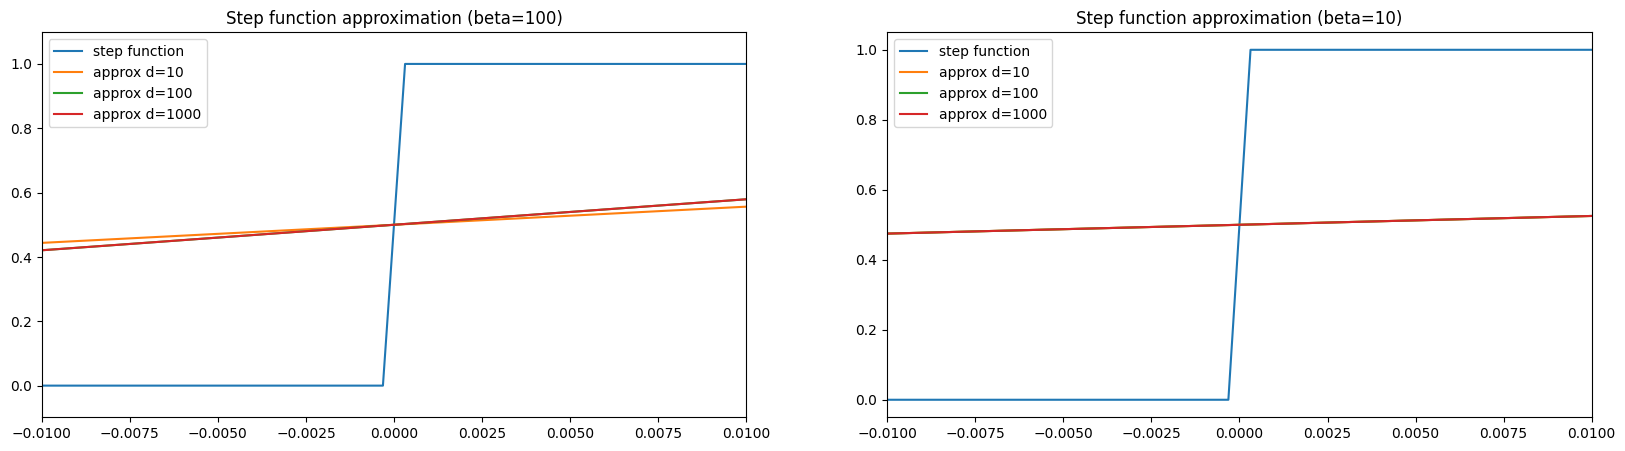

In [19]:
x_list = np.linspace(-pi,pi,10000)
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(x_list,list(np.zeros(len(x_list)//2))+list(np.ones(len(x_list)//2)),label='step function')
ax[0].plot(x_list,get_approx_step_function(d=10,beta=100),label='approx d=10')
ax[0].plot(x_list,get_approx_step_function(d=100,beta=100),label='approx d=100')
ax[0].plot(x_list,get_approx_step_function(d=1000,beta=100),label='approx d=1000')
ax[0].set_title('Step function approximation (beta=100)')
ax[0].legend()
ax[0].set_xlim([-.01,.01])

ax[1].plot(x_list,list(np.zeros(len(x_list)//2))+list(np.ones(len(x_list)//2)),label='step function')
ax[1].plot(x_list,get_approx_step_function(d=10,beta=10),label='approx d=10')
ax[1].plot(x_list,get_approx_step_function(d=100,beta=10),label='approx d=100')
ax[1].plot(x_list,get_approx_step_function(d=1000,beta=10),label='approx d=1000')
ax[1].set_title('Step function approximation (beta=10)')
ax[1].set_xlim([-.01,.01])
ax[1].legend()

In [20]:
## Use the get_new_Z instead.

# def get_Z(N_sites, t, U, tau, j, step, shots):
    
#     qc_real = get_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='real')
#     qc_imag = get_Hadamard_circuit(N_sites, t, U, tau, j, step, test_type='imag')
    
#     device = LocalSimulator()
#     job_real = device.run(qc_real, shots=shots)
#     job_imag = device.run(qc_imag, shots=shots)
#     res_real = job_real.result()
#     res_imag = job_imag.result()
#     prob_real = res_real.values[0]
#     prob_imag = res_imag.values[0]
    
#     Z = (prob_real[0]-prob_real[1])+1j*(prob_imag[0]-prob_imag[1])
    
#     return Z

In [21]:
def get_Z_list(d, N_sites, t, U, tau, step, shots_per_run): ## shots_per_run should be replaced
    
    Z_list = [get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_per_run) for j in range(d+1)]
    
    return Z_list

In [22]:
#get_Z_list(d=20,N_sites=4, t=1, U=4, tau=0.0185533,step=1, shots_per_run=1000)
get_new_Z(4, 1, 4, tau, 5, 1, 10000)

(0.9017593468936708+0.37557518593472117j)

\begin{equation}
ACDF(x) = 0.5+\sum^d_{j=0} F_j e^{i(2j+1)x} Z_j
\end{equation}


In [24]:
def Assembly_ACDF(Z_list, F_list, precision):
    
    ACDF = .5*np.ones(precision)
    x_list = np.linspace(-pi,pi,precision)
    d = len(F_list)-1
    
    for j in range(d+1):
        ACDF = ACDF + F_list[j]*Z_list[j]*np.exp(1j*(2*j+1)*x_list) - F_list[j]*Z_list[j].conj()*np.exp(-1j*(2*j+1)*x_list)
        #ACDF = ACDF + F_list[j]*Z_list[j]*2j*np.sin((2*j+1)*x_list)
                                                                              
    return ACDF

In [25]:
Z_list

NameError: name 'Z_list' is not defined

In [26]:
Z_list = get_Z_list(50, 4, 1, 4, tau, 1, 10000)
F_list = get_F_coefs(d=50, beta=50)
ACDF = Assembly_ACDF(Z_list, F_list, 10000)

/Users/dranz/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-1.0471975511965976, 1.0471975511965976)

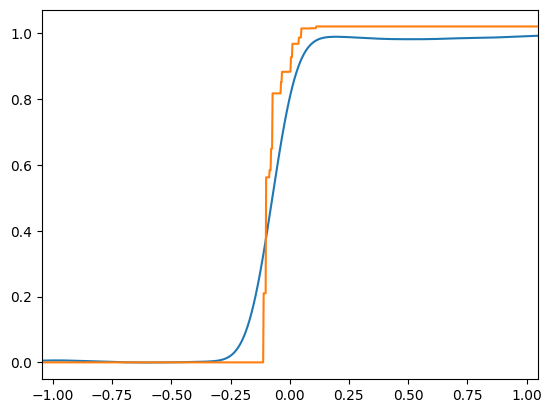

In [27]:
plt.plot(np.linspace(-pi,pi,10000), ACDF)
plt.plot(np.linspace(-np.pi/3, np.pi/3, 1000), get_real_CDF(4,1,4,precision=1000), label='CDF')
plt.xlim([-pi/3, pi/3])